In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_data():
    size = 1000
    x = np.linspace(0, 1, size)
    y = -10*x + 5
    y += 15*np.logical_and(x > 0.75, x < 0.8).astype(float)
    return x, y

# 1. Inspect the data (0.5 points)

Using `matplotlib`, create a scatter plot of the data returned by `generate_data()`.
What is out of the ordinary about this line?

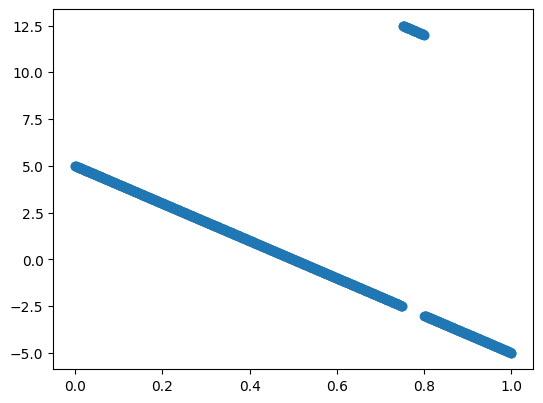

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.6])

plt.scatter(generate_data()[0], generate_data()[1])
plt.show()



This line is out of the ordinary because it is nearly a perfect linear continuous function, with the exception of the range [0.75, 0.8] along the x-axis, where the function is shifted upwards by 15 - making it a discontinuous piecewise function. If this were a real dataset, it is likely the data along x = [0.75, 0.8] is an outlier.

# 2. Implement linear regression (2.5 points)

Implement a basic linear regression model which is fit to the data from `generate_data` using gradient descent.
Your model should take the form `y = m*x + b`, where `y` is the output, `x` is the input, `m` is a weight parameter, and `b` is a bias parameter.
You must use only `numpy` and derive any derivatives yourself (i.e. no autograd from TensorFlow, MXNet, Pytorch, JAX etc!).
You should use a squared-error loss function.
You are welcome to use any technique you want to decide when to stop training.
Make sure you tune your optimization hyperparameters so that the model converges.
Print out or plot the loss over the course of training.

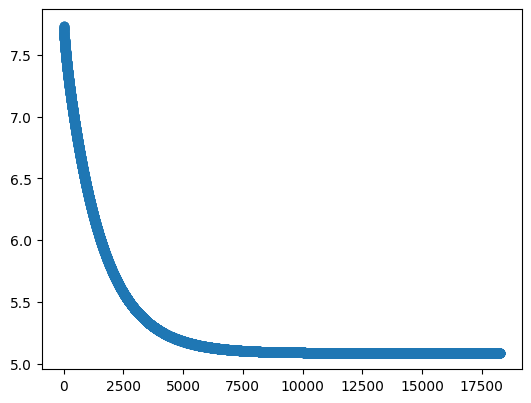

In [ ]:
## Define the LinReg as a class, with a model function to produce y_hat, a loss function (for MSE) and an optimization function (batch gradient descent)

class LinReg:
  def __init__(self, X, y, m=0, b=0):
    self.losses = []
    self.X = X
    self.y = y
    self.m = m
    self.b = b


  def model(self):
    return self.m*self.X + self.b

  def MSE(self, y_hat):
    loss = 0.5*(y_hat - self.y)**2
    return loss.mean()

  def SGD(self, y_hat, lr):
    db = sum(y_hat - self.y)
    dm = sum((y_hat - self.y)*self.X)
    self.m -= lr/len(self.X)*dm
    self.b -= lr/len(self.X)*db

  def train(self, lr):
    i = 0
    while True:
      y_hat = self.model()
      loss = self.MSE(y_hat)
      self.losses.append(loss)
      self.SGD(y_hat, lr)
      i += 1
      if i>10:
        # Once the loss has stopped decreasing meaningfully, stop training
        if (self.losses[i-1] + 0.0000001) > self.losses[i-11]:
          return y_hat


# by default, our model has parameters inialized to 0
# use learning rate of 0.005

linregmodel = LinReg(generate_data()[0], generate_data()[1])
y_model = linregmodel.train(0.005)

# Plot our train loss. It appears to converge at a MSE of around 5.1

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.6])

plt.scatter(range(len(linregmodel.losses)), linregmodel.losses)
plt.show()








# 3. Analyze the result (0.5 points)

Print out the values of `w` and `b` found by your model after training and compare them to the ground truth values (which can be found inside the code of the `generate_data` function).
Are they close?
Recreate the scatter plot you generated in question 1 and plot the model as a line on the same plot.
What went wrong?


Value of w:  -7.508587299960405 
Ground truth value of w: -10
Value of b:  4.503627793544 
Ground truth value of b: 5


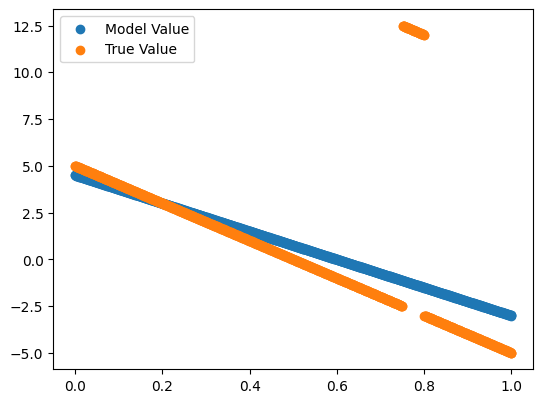

In [ ]:
print("Value of w: ", linregmodel.m, "\nGround truth value of w: -10\nValue of b: ", linregmodel.b, "\nGround truth value of b: 5" )

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.6])

plt.scatter(generate_data()[0], y_model, label="Model Value")
plt.scatter(generate_data()[0], generate_data()[1], label="True Value")
plt.legend()
plt.show()



The bias value from the model is reasonably close (off by ~10%) to the true value.
The weight value from the model is less close (off by ~25%) to the true value.
The outliers in the data from x=[0.75,0.8] caused the model to not find the true values of the weight and bias.
Since the data in this range is shifted upward, and the line is downward sloping, the model (which considers these outliers) weight (slope in this 1D case) is too low. In turn, the error in the model's slope causes the bias to also differ from its ground tuth value.
Since the SGD with the L2 loss function considers the magnitude of the error abs(y_hat - y), and the outliers in this function are fairly extreme, this causes substantial errors in having the model converge to the ground truth parameters.

# 4. "Robust" linear regression (1 point)

Implement a linear regression model exactly like the one you created in question 2, except using a L1 loss (absolute difference) instead of a squared L2 loss (squared error).
You should be able to copy and paste your code from question 2 and only change a few lines.
Print out or plot the loss over the course of training.
What is different about the loss trajectory compared to the squared-error linear regression?

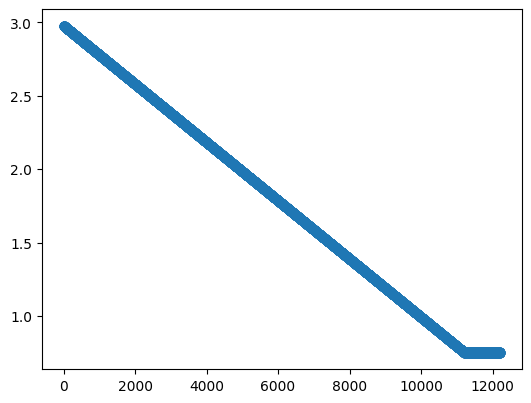

In [ ]:
## Define the LinReg as a class, with a model function to produce y_hat, a loss function (for MSE) and an optimization function (batch gradient descent)

class LinRegL1:
  def __init__(self, X, y, m=0, b=0):
    self.losses = []
    self.X = X
    self.y = y
    self.m = m
    self.b = b


  def model(self):
    return self.m*self.X + self.b

  def L1(self, y_hat):
    loss = np.abs(y_hat - self.y)
    return loss.mean()

  def SGD(self, y_hat, lr):

    # keep track of if y_hat > y
    flags = np.zeros(len(generate_data()[1]))
    for i in range(len(generate_data()[1])):
      if (y_hat[i] > self.y[i]):
        flags[i] = 1
      elif (y_hat[i] < self.y[i]):
        flags[i] = -1

    db = sum(flags)
    dm = sum(flags*self.X)
    self.m -= lr/len(self.X)*dm
    self.b -= lr/len(self.X)*db

  def train(self, lr):
    i = 0
    while i<30000:
      y_hat = self.model()
      loss = self.L1(y_hat)
      self.losses.append(loss)
      self.SGD(y_hat, lr)
      i += 1
      if i>1000:
        # Once the loss has stopped decreasing meaningfully, stop training
        ## Note, I changed the criterion here from the previous implementation with MSE, because the loss stops improving suddenly, and I wanted to make sure the model
        ## would not continue improving if I loosened the stoping criteria.
        if (self.losses[i-1] + 0.0001) > self.losses[i-1001]:
          return y_hat


# by default, our model has parameters inialized to 0
# use learning rate of 0.005

linregmodel_robust = LinRegL1(generate_data()[0], generate_data()[1])
y_model_robust = linregmodel_robust.train(0.005)

# Plot our train loss. It appears to converge at a MSE of around 5.1

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.6])

plt.scatter(range(len(linregmodel_robust.losses)), linregmodel_robust.losses)
plt.show()



Comparing the plot below with that from Q2, it is clear that with the L2 loss function, the loss continues to improve at a decelerating rate, until a point where it plateaus.
With the L1 loss function, the loss decreases at a constant rate, until a point where it stops decreasing altogether. This is because the gradient of L2 wrt parameters is a continuous function, which depends on the size of abs(y_hat-y),
while the gradient of L1 wrt parameters is non-continuous, and the adjustment to the parameters based on SGD does not depend on the magnitude of abs(y_hat - y).

# 5. Analyze the result (0.5 points)

Print out the new values of `w` and `b` found by your model after training.
Are they closer to the true values used in `generate_data`?
Plot the model as a line again.
Why do you think the behavior is different?

Value of w:  -9.999074864865092 
Ground truth value of w: -10
Value of b:  4.998990000000964 
Ground truth value of b: 5


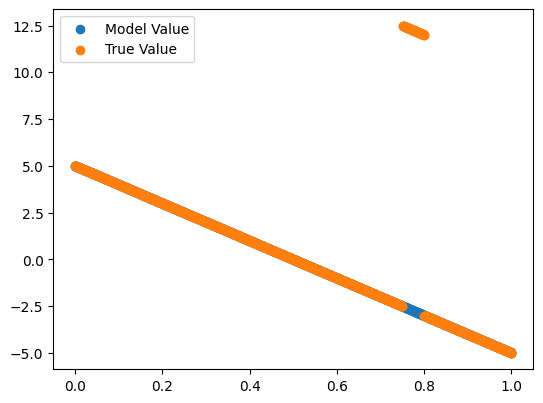

In [ ]:
print("Value of w: ", linregmodel_robust.m, "\nGround truth value of w: -10\nValue of b: ", linregmodel_robust.b, "\nGround truth value of b: 5" )

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.6])

plt.scatter(generate_data()[0], y_model_robust, label="Model Value")
plt.scatter(generate_data()[0], generate_data()[1], label="True Value")
plt.legend()
plt.show()




The bias and weight values from the model are nearly equal to the ground truth values, which is clear from how the model line in the plot below overlaps with the true values outside the range x=[0.75,0.8]. This performance is much better than when the L2 loss function was used.

The behavior is different because when L1 loss is used, the parameter updates do not depend on the magnitude abs(y_hat - y). Instead, they only depend on the frequency with which (y_hat > y) abd vice-versa. Because of the structure of the data where there are a small amount of extreme outliers, this allows better performance since when L2 is used the extreme outliers have an outsized impact on the model training when the SGD depends on the magnitude of (y_hat - y).